Choose analysis type:
1. Single-subject analysis
2. Group analysis

Running single-subject analysis...
PSD VOXEL ANALYSIS: DUAL METHODS (MULTITAPER + WELCH)
Region 1: Cortical Hand Knob - Left Anterior → MNI [-37, -9, 67]
Region 2: Cortical Hand Knob - Left Posterior → MNI [-42, -20, 67]
Region 3: Cortical Hand Knob - Right Anterior → MNI [38, -7, 66]
Region 4: Cortical Hand Knob - Right Posterior → MNI [42, -18, 66]
Region 5: Primary Motor Cortex (M1) - Right → MNI [40, -14, 46]
Region 6: Subthalamic Nucleus (STN) - Left → MNI [-11.89, -14.51, -6.4]
Region 7: Subthalamic Nucleus (STN) - Right → MNI [12.53, -13.97, -6.57]
Region 8: Primary Visual Cortex (V1) - Left → MNI [-8, -76, 10]
Region 9: Primary Visual Cortex (V1) - Right → MNI [7, -76, 10]


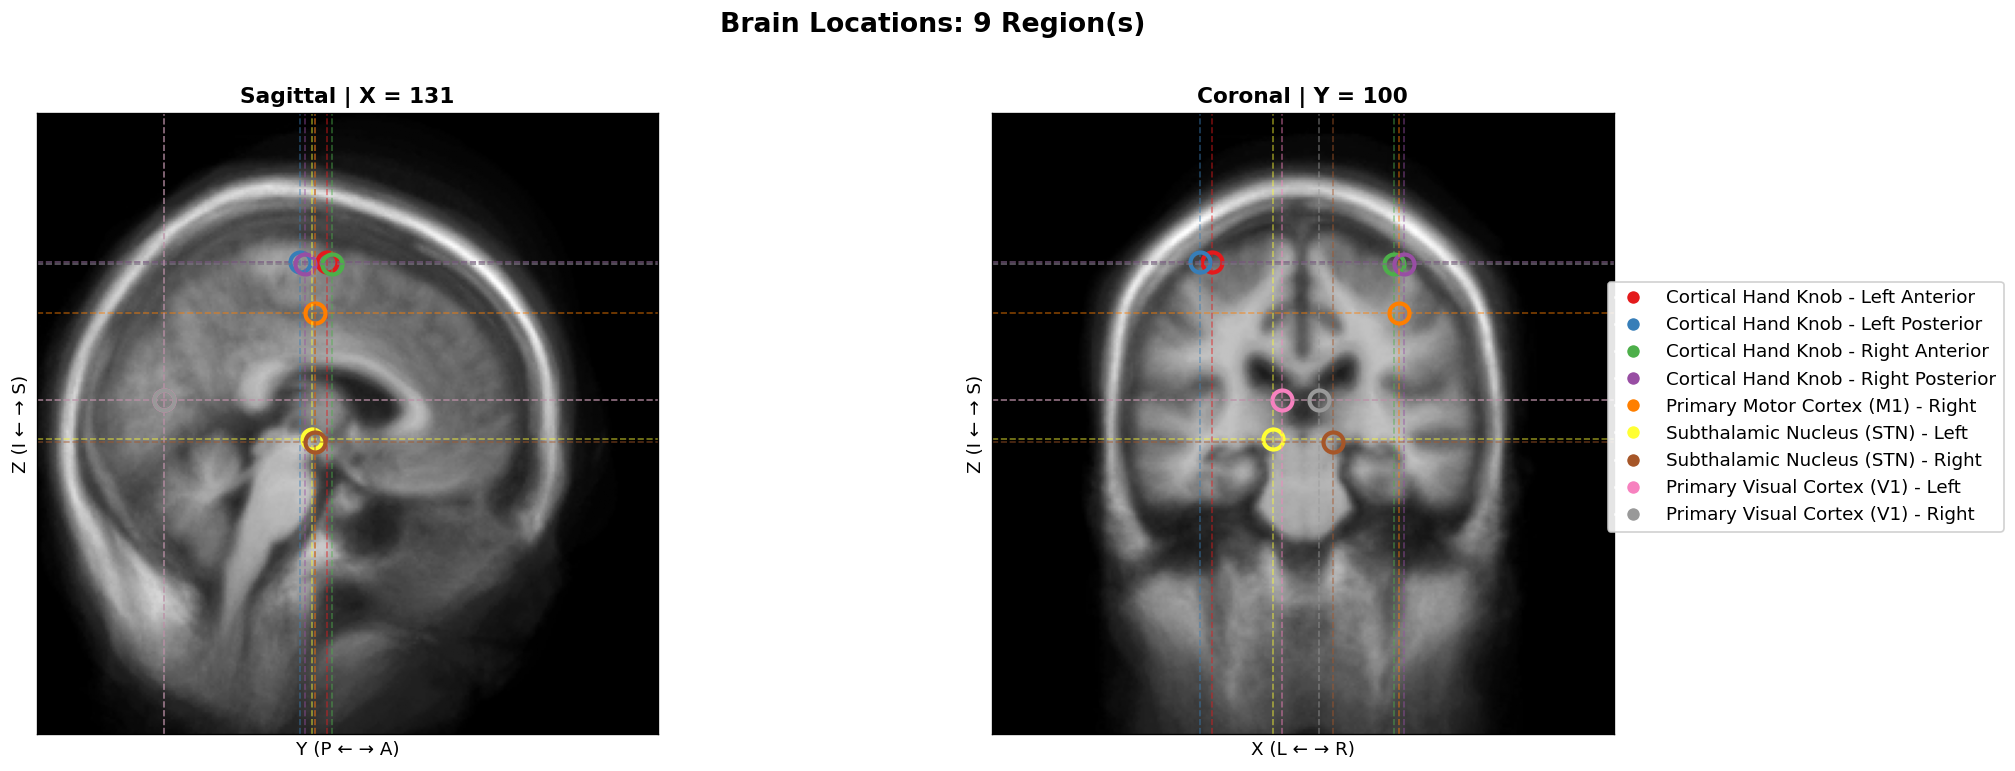

📊 Analyzing Bima Activity...
  Condition Bima Activity completed in 0.00s
❌ Error: No STC found in /home/jaizor/jaizor/xtra/derivatives/source_analysis/sbj06_lcmv_Bima_Activity


Traceback (most recent call last):
  File "/tmp/ipykernel_125302/273190307.py", line 391, in analyze
    results_cond = self.analyze_condition(
        condition=cond_key,
    ...<2 lines>...
        use_3x3x3_avg=use_3x3x3_avg
    )
  File "/tmp/ipykernel_125302/273190307.py", line 316, in analyze_condition
    stc = self._load_stc(condition)
  File "/tmp/ipykernel_125302/273190307.py", line 92, in _load_stc
    self._stcs[condition] = self._load_stc_from_dir(self.paths[condition])
                            ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_125302/273190307.py", line 83, in _load_stc_from_dir
    raise FileNotFoundError(f"No STC found in {base_dir}")
FileNotFoundError: No STC found in /home/jaizor/jaizor/xtra/derivatives/source_analysis/sbj06_lcmv_Bima_Activity


In [3]:
# Optimized Group PSD Voxel Analyzer (Enhanced Version)
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from scipy import signal
import nibabel as nib
from functools import lru_cache
import warnings
import logging
from dataclasses import dataclass
import time
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Suppress warnings and configure logging
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('PSDVoxelAnalyzer')

@dataclass
class Config:
    PROJECT_BASE: str = '/home/jaizor/jaizor/xtra'
    SFREQ: float = 500.0
    PSD_WINDOW_SEC: float = 2.0
    FREQ_BANDS = {
        'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12),
        'Low_Beta': (12, 20), 'High_Beta': (20, 30),
        'Low_Gamma': (30, 50), 'High_Gamma': (50, 100)
    }

class PSDVoxelAnalyzer:
    """Enhanced PSD voxel analysis with dual methods and coordinate plotting."""
    
    def __init__(self, paths_dict, project_base=None, config=None):
        self.paths = {k: Path(v) for k, v in paths_dict.items()}
        self.config = config or Config()
        if project_base:
            self.config.PROJECT_BASE = project_base
        self.project_base = Path(self.config.PROJECT_BASE)
        
        # Cache for loaded data
        self._stcs = {}
        self._source_points = None
        self._t1_img = None

    @property
    def subjects_dir(self):
        return self.project_base / "derivatives/lcmv"

    def _timer(self, operation_name):
        """Simple timer context manager."""
        class Timer:
            def __init__(self, name):
                self.name = name
                self.start = None
            def __enter__(self):
                self.start = time.time()
                return self
            def __exit__(self, *args):
                elapsed = time.time() - self.start
                print(f"  {self.name} completed in {elapsed:.2f}s")
        return Timer(operation_name)

    def _load_stc_from_dir(self, base_dir):
        """Load STC from directory: try .h5 first, then fall back to metadata."""
        h5_path = base_dir / "source_estimate_LCMV.h5"
        if h5_path.exists():
            return mne.read_source_estimate(str(h5_path))

        meta_path = base_dir / "computation_metadata.pkl"
        if meta_path.exists():
            with open(meta_path, 'rb') as f:
                meta = pickle.load(f)
            stc_path = Path(meta['stc_file'])
            if not stc_path.exists():
                stc_path = base_dir / stc_path.name
            if stc_path.exists():
                return mne.read_source_estimate(str(stc_path))
        
        raise FileNotFoundError(f"No STC found in {base_dir}")

    @lru_cache(maxsize=4)
    def _load_stc(self, condition):
        """Load STC with caching."""
        if condition not in self.paths:
            raise ValueError(f"Condition '{condition}' not found in paths")
        
        if condition not in self._stcs:
            self._stcs[condition] = self._load_stc_from_dir(self.paths[condition])
        return self._stcs[condition]

    @lru_cache(maxsize=1)
    def _load_source_points(self):
        """Load source points once."""
        for path in self.paths.values():
            points_path = path / "source_space_points_mm.npy"
            if points_path.exists():
                return np.load(points_path)
        raise FileNotFoundError("source_space_points_mm.npy not found")

    @lru_cache(maxsize=1)
    def _load_t1_image(self):
        """Load and reorient T1 image to standard RAS."""
        t1_path = self.subjects_dir / "fsaverage/mri/T1.mgz"
        if not t1_path.exists():
            raise FileNotFoundError(f"T1.mgz not found: {t1_path}")
        img = nib.load(str(t1_path))
        return nib.as_closest_canonical(img)

    def _get_colors(self, n_regions, cmap='Set1'):
        """Generate colors for regions."""
        cmap_func = plt.colormaps[cmap]
        return [cmap_func(i % cmap_func.N) for i in range(n_regions)]

    def _find_nearest_voxels(self, coordinates):
        """Vectorized voxel finding."""
        source_points = self._load_source_points()
        results = []
        for coord in coordinates:
            distances = np.linalg.norm(source_points - np.array(coord), axis=1)
            idx = np.argmin(distances)
            actual_coord = source_points[idx]
            results.append((idx, actual_coord, distances[idx]))
        return results

    @lru_cache(maxsize=1)
    def _get_source_grid_shape(self):
        """Get source grid shape for 3x3x3 averaging."""
        points = self._load_source_points()
        x_vals = np.unique(np.round(points[:, 0], 3))
        y_vals = np.unique(np.round(points[:, 1], 3))
        z_vals = np.unique(np.round(points[:, 2], 3))
        return (len(x_vals), len(y_vals), len(z_vals))

    def _mni_to_index(self, coord):
        """Convert MNI coordinate to grid indices."""
        points = self._load_source_points()
        shape = self._get_source_grid_shape()
        x_vals = np.unique(np.round(points[:, 0], 3))
        y_vals = np.unique(np.round(points[:, 1], 3))
        z_vals = np.unique(np.round(points[:, 2], 3))

        def find_closest(array, value):
            return np.argmin(np.abs(array - value))

        x_idx = find_closest(x_vals, coord[0])
        y_idx = find_closest(y_vals, coord[1])
        z_idx = find_closest(z_vals, coord[2])
        return x_idx, y_idx, z_idx

    def _extract_time_series(self, stc, voxel_idx, use_3x3x3_avg=False):
        """Extract time series with optional 3x3x3 spatial averaging."""
        if not use_3x3x3_avg:
            return stc.data[voxel_idx, :]

        x, y, z = self._mni_to_index(self._load_source_points()[voxel_idx])
        shape = self._get_source_grid_shape()
        neighbors = []

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                for dz in [-1, 0, 1]:
                    nx, ny, nz = x + dx, y + dy, z + dz
                    if (0 <= nx < shape[0]) and (0 <= ny < shape[1]) and (0 <= nz < shape[2]):
                        try:
                            idx_1d = np.ravel_multi_index((nx, ny, nz), shape)
                            if idx_1d < stc.data.shape[0]:
                                neighbors.append(stc.data[idx_1d, :])
                        except ValueError:
                            continue

        return np.mean(np.array(neighbors), axis=0) if neighbors else stc.data[voxel_idx, :]

    def _compute_psd_dual(self, time_series, sfreq):
        """Compute PSD using both multitaper and Welch methods."""
        from mne.time_frequency import psd_array_multitaper
        
        time_series = np.real(time_series)
        window_size = int(self.config.PSD_WINDOW_SEC * sfreq)
        
        if len(time_series) < window_size:
            raise ValueError(f"Time series too short for {self.config.PSD_WINDOW_SEC}s window")
        
        # Trim and filter
        n_windows = len(time_series) // window_size
        trimmed = time_series[:n_windows * window_size]
        
        # High-pass filter at 0.5 Hz
        nyq = sfreq * 0.5
        b, a = signal.butter(4, 0.5 / nyq, btype='high')
        filtered = signal.filtfilt(b, a, trimmed)
        
        results = {}
        
        # Multitaper
        try:
            windows = filtered.reshape(n_windows, window_size)
            psds_mt = []
            for window in windows:
                psd_mt, freqs_mt = psd_array_multitaper(
                    x=window, sfreq=sfreq, fmin=1, fmax=100,
                    bandwidth=None, adaptive=False, normalization='length',
                    low_bias=True, verbose=False, n_jobs=1
                )
                psds_mt.append(psd_mt)
            
            results['multitaper'] = {
                'freqs': freqs_mt,
                'psd': np.mean(psds_mt, axis=0)
            }
        except Exception as e:
            logger.warning(f"Multitaper failed: {e}")
        
        # Welch
        freqs_w, psd_w = signal.welch(
            filtered, fs=sfreq, window='hann', nperseg=window_size,
            noverlap=window_size // 2, detrend='constant'
        )
        mask = (freqs_w >= 1) & (freqs_w <= 100)
        results['welch'] = {
            'freqs': freqs_w[mask],
            'psd': psd_w[mask]
        }
        
        return results, filtered

    def _compute_band_powers(self, freqs, psd):
        """Compute band powers from PSD."""
        band_powers = {}
        for band_name, (low, high) in self.config.FREQ_BANDS.items():
            mask = (freqs >= low) & (freqs <= high)
            power = np.mean(psd[mask]) if mask.any() else 0.0
            band_powers[band_name] = {
                'power': power,
                'freqs': freqs,
                'psd': psd,
                'mask': mask
            }
        return band_powers

    def plot_orthoview(self, coordinates, region_names, colors=None, 
                      figsize=(18, 7), marker_size=12):
        """Plot sagittal and coronal views with brain coordinates."""
        if colors is None:
            colors = self._get_colors(len(region_names))
            
        img = self._load_t1_image()
        data = img.get_fdata()
        inv_affine = np.linalg.inv(img.affine)

        coords_array = np.array(coordinates)
        homog = np.column_stack([coords_array, np.ones(len(coords_array))])
        voxel_coords = (inv_affine @ homog.T).T[:, :3].round().astype(int)

        cx, cy, _ = voxel_coords.mean(axis=0).astype(int)

        fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=120, 
                               gridspec_kw={'width_ratios': [1, 1.2]})

        legend_items = [
            plt.Line2D([0], [0], marker='o', color='w', label=name,
                       markerfacecolor=color, markersize=10, markeredgewidth=2.5)
            for name, color in zip(region_names, colors)
        ]

        views = [
            (cx, data[cx, :, :], "Sagittal", "X", "Y (P ← → A)", "Z (I ← → S)", 
             lambda v: (v[1], v[2])),
            (cy, data[:, cy, :], "Coronal", "Y", "X (L ← → R)", "Z (I ← → S)", 
             lambda v: (v[0], v[2]))
        ]

        for ax_idx, (center, slice_data, view_name, axis_name, xlabel, ylabel, coord_func) in enumerate(views):
            ax = axes[ax_idx]
            if 0 <= center < slice_data.shape[0]:
                ax.imshow(slice_data.T, cmap="gray", origin="lower")
                ax.set_title(f"{view_name} | {axis_name} = {center}", 
                           fontsize=13, fontweight='bold')
            else:
                ax.text(0.5, 0.5, "Out of Range", ha="center", color="red", 
                       transform=ax.transAxes)
            
            ax.set_xlabel(xlabel, fontsize=11)
            ax.set_ylabel(ylabel, fontsize=11)
            ax.set_xticks([])
            ax.set_yticks([])

            for voxel, color in zip(voxel_coords, colors):
                plot_x, plot_y = coord_func(voxel)
                ax.plot(plot_x, plot_y, 'o', color=color, ms=marker_size, 
                       mfc='none', mew=2.5)
                ax.axvline(plot_x, color=color, ls='--', alpha=0.5, lw=1)
                ax.axhline(plot_y, color=color, ls='--', alpha=0.5, lw=1)

        fig.legend(
            handles=legend_items,
            loc='center right',
            bbox_to_anchor=(1.0, 0.5),
            frameon=True,
            framealpha=0.9,
            fontsize=11,
            borderaxespad=0.5
        )

        fig.suptitle(f"Brain Locations: {len(coordinates)} Region(s)", 
                    fontsize=16, fontweight='bold', y=0.97)
        fig.subplots_adjust(right=0.85, wspace=0.35, top=0.85, left=0.08)
        plt.show()
        return fig

    def analyze_condition(self, condition, coordinates, region_names, use_3x3x3_avg=True):
        """Analyze one condition efficiently."""
        stc = self._load_stc(condition)
        voxel_info = self._find_nearest_voxels(coordinates)
        results = []
        
        for (voxel_idx, actual_coord, distance), coord, name in zip(
            voxel_info, coordinates, region_names
        ):
            time_series = self._extract_time_series(stc, voxel_idx, use_3x3x3_avg)
            psd_results, filtered_ts = self._compute_psd_dual(time_series, self.config.SFREQ)
            
            # Compute band powers using multitaper (more accurate)
            if 'multitaper' in psd_results:
                freqs_mt = psd_results['multitaper']['freqs']
                psd_mt = psd_results['multitaper']['psd']
                band_powers = self._compute_band_powers(freqs_mt, psd_mt)
            else:
                band_powers = {}
            
            results.append({
                'region_name': name,
                'condition': condition,
                'requested_coords': coord,
                'actual_coords': actual_coord,
                'voxel_idx': voxel_idx,
                'distance': distance,
                'psd_dual': psd_results,
                'band_powers': band_powers,
                'n_samples': len(time_series),
                'duration_sec': len(time_series) / self.config.SFREQ,
                'used_3x3x3_avg': use_3x3x3_avg
            })
        
        return results

    def analyze(self, coordinates, region_names=None, show_orthoview=True, 
                show_psd_plots=True, cmap='Set1', ortho_figsize=(18, 7), 
                marker_size=12, use_3x3x3_avg=True):
        """Main single-subject analysis method."""
        # Input validation
        if isinstance(coordinates[0], (int, float)):
            coordinates = [coordinates]
        if region_names is None:
            region_names = [f"Region_{i+1}" for i in range(len(coordinates))]
        if len(coordinates) != len(region_names):
            raise ValueError("coordinates and region_names must have the same length")

        print("=" * 60)
        print("PSD VOXEL ANALYSIS: DUAL METHODS (MULTITAPER + WELCH)")
        print("=" * 60)
        for i, (coord, name) in enumerate(zip(coordinates, region_names)):
            print(f"Region {i+1}: {name} → MNI {coord}")
        print("=" * 60)

        try:
            colors = self._get_colors(len(region_names), cmap)

            # Show brain locations
            if show_orthoview:
                self.plot_orthoview(coordinates, region_names, colors, 
                                  ortho_figsize, marker_size)

            # Analyze all conditions
            all_results = []
            condition_labels = {
                'bima_activity': 'Bima Activity',
                'hands_move': 'Hands Move',
                'rest_closed': 'Rest Eyes Closed',
                'rest_open': 'Rest Eyes Open'
            }
            
            for cond_key in self.paths.keys():
                label = condition_labels.get(cond_key, cond_key)
                print(f"📊 Analyzing {label}...")
                
                with self._timer(f"Condition {label}"):
                    results_cond = self.analyze_condition(
                        condition=cond_key,
                        coordinates=coordinates,
                        region_names=region_names,
                        use_3x3x3_avg=use_3x3x3_avg
                    )
                    all_results.extend(results_cond)

            # Plot PSDs
            if show_psd_plots:
                self.plot_psd_dual(all_results)

            print(f"\n✅ Analysis complete for {len(coordinates)} region(s)")
            return {
                'coordinates_requested': coordinates,
                'region_names': region_names,
                'results': all_results,
                'metadata': {
                    'paths': {k: str(v) for k, v in self.paths.items()},
                    'sampling_rate': self.config.SFREQ,
                    'project_base': str(self.project_base),
                    'use_3x3x3_avg': use_3x3x3_avg,
                    'psd_methods': ['multitaper', 'welch'],
                    'window_sec': self.config.PSD_WINDOW_SEC
                }
            }

        except Exception as e:
            print(f"❌ Error: {e}")
            import traceback
            traceback.print_exc()
            return None

    def plot_psd_dual(self, results, frequency_range=(1, 100), log_scale=True, figsize=(14, 6)):
        """Enhanced PSD plotting with proper styling."""
        import seaborn as sns
        sns.set_theme(style="whitegrid", context="talk")

        # Group results by region and condition
        regions = {}
        for r in results:
            name = r['region_name']
            if name not in regions:
                regions[name] = {}
            regions[name][r['condition']] = r

        # Styling
        condition_labels = {
            'bima_activity': 'Bima Activity',
            'hands_move': 'Hands Move',
            'rest_closed': 'Rest Eyes Closed',
            'rest_open': 'Rest Eyes Open'
        }
        condition_colors = {
            'bima_activity': 'orange',
            'hands_move': 'red',
            'rest_closed': 'blue',
            'rest_open': 'green'
        }
        band_colors = {
            'Delta': 'lightsalmon', 'Theta': 'wheat', 'Alpha': 'mediumpurple',
            'Low_Beta': 'skyblue', 'High_Beta': 'lightcoral',
            'Low_Gamma': 'lightgreen', 'High_Gamma': 'plum'
        }

        for region_name, data in regions.items():
            print(f"\n📊 Plotting PSDs for: {region_name}")

            for method_name in ['welch', 'multitaper']:
                fig, ax = plt.subplots(figsize=figsize)
                method_title = "Welch (Hann)" if method_name == 'welch' else "Multitaper"
                ax.set_title(f"PSD - {region_name} | Method: {method_title}", 
                           fontsize=14, pad=20)

                # Plot each condition
                for cond_key, result in data.items():
                    if method_name in result['psd_dual']:
                        psd_data = result['psd_dual'][method_name]
                        freqs = psd_data['freqs']
                        psd = psd_data['psd']

                        # Apply frequency range
                        mask = (freqs >= frequency_range[0]) & (freqs <= frequency_range[1])
                        freqs = freqs[mask]
                        psd = psd[mask]

                        # Plot
                        plot_func = ax.semilogy if log_scale else ax.plot
                        label = condition_labels.get(cond_key, cond_key)
                        color = condition_colors.get(cond_key, 'gray')
                        plot_func(freqs, psd, label=label, linewidth=2.5, color=color)

                # Shade frequency bands
                for band, (low, high) in self.config.FREQ_BANDS.items():
                    if low >= frequency_range[0] and high <= frequency_range[1]:
                        ax.axvspan(low, high, color=band_colors[band], alpha=0.15, label=band)

                # Formatting
                ax.set_xlim(frequency_range)
                ax.set_xlabel("Frequency (Hz)")
                ax.set_ylabel("Power" + (" (log)" if log_scale else ""))
                ax.grid(True, which="both", axis="y", alpha=0.3)
                ax.grid(True, axis="x", alpha=0.1)

                # Legend
                handles, labels = ax.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                fig.legend(
                    by_label.values(), by_label.keys(),
                    loc='center left', bbox_to_anchor=(1.0, 0.5),
                    frameon=True, fancybox=True, shadow=True, fontsize=10
                )
                fig.subplots_adjust(left=0.1, right=0.78, top=0.85, bottom=0.15)
                plt.show()

        sns.reset_orig()


class GroupPSDAnalyzer:
    """Enhanced group-level analysis with coordinate plotting."""
    
    def __init__(self, lcmv_base_dir, project_base="/home/jaizor/jaizor/xtra"):
        self.lcmv_base_dir = Path(lcmv_base_dir)
        self.project_base = Path(project_base)
        self.config = Config(PROJECT_BASE=project_base)
        
        # Auto-detect subjects and conditions
        self.subject_folders = self._find_subject_folders()
        self.subjects = self._extract_subjects()
        
        logger.info(f"Found {len(self.subjects)} subjects")

    def _find_subject_folders(self):
        """Find subject folders matching pattern."""
        return [f for f in self.lcmv_base_dir.iterdir() 
                if f.is_dir() and f.name.startswith('sub') and '_lcmv_' in f.name]

    def _extract_subjects(self):
        """Extract unique subject IDs."""
        subjects = set()
        for folder in self.subject_folders:
            match = re.search(r'(sub\d+)_lcmv_', folder.name)
            if match:
                subjects.add(match.group(1))
        return sorted(subjects)

    def _parse_folder_name(self, folder_name):
        """Parse condition and med state from folder name."""
        parts = folder_name.lower().split('_')
        
        try:
            lcmv_idx = parts.index('lcmv')
        except ValueError:
            return None, None
        
        condition_parts = parts[lcmv_idx + 1:-1]
        condition_raw = '_'.join(condition_parts)
        med_state = parts[-1]
        
        # Map conditions
        condition_map = {
            'bima': 'bima_activity',
            'hands': 'hands_move',
            'rest': 'rest_eyes_closed',
            'eyes_closed': 'rest_eyes_closed',
            'eyes_open': 'rest_eyes_open'
        }
        
        condition = condition_map.get(condition_raw, condition_raw)
        
        if condition in ['bima_activity', 'hands_move', 'rest_eyes_closed', 'rest_eyes_open'] and \
           med_state in ['off']:
            return condition, med_state
        
        return None, None

    def _group_folders(self):
        """Group folders by condition and medication state."""
        groups = {}
        for folder in self.subject_folders:
            condition, med_state = self._parse_folder_name(folder.name)
            if condition and med_state:
                key = (condition, med_state)
                groups.setdefault(key, []).append(folder)
        return groups

    def _process_single_subject(self, args):
        """Process single subject - for parallel execution."""
        folder, condition, coordinates, region_names, use_3x3x3_avg = args
        
        try:
            analyzer = PSDVoxelAnalyzer(
                {condition: folder}, 
                project_base=str(self.project_base),
                config=self.config
            )
            return analyzer.analyze_condition(
                condition, coordinates, region_names, use_3x3x3_avg
            )
        except Exception as e:
            logger.warning(f"Failed to process {folder.name}: {e}")
            return []

    def analyze_group(self, coordinates, region_names=None, use_3x3x3_avg=True, 
                    show_orthoview=True, parallel=True, max_workers=None):
        """Enhanced group analysis with coordinate plotting."""
        if region_names is None:
            region_names = [f"Region_{i+1}" for i in range(len(coordinates))]
        
        # Show coordinate plot using first available subject
        if show_orthoview and self.subject_folders:
            try:
                first_folder = self.subject_folders[0]
                first_condition = 'bima_activity'  # Default condition
                
                analyzer = PSDVoxelAnalyzer(
                    {first_condition: first_folder},
                    project_base=str(self.project_base),
                    config=self.config
                )
                colors = analyzer._get_colors(len(region_names))
                analyzer.plot_orthoview(coordinates, region_names, colors)
            except Exception as e:
                logger.warning(f"Could not show orthoview: {e}")

        groups = self._group_folders()
        group_results = {}
        
        # Determine number of workers
        if max_workers is None:
            max_workers = min(mp.cpu_count(), 4)
        
        for (condition, med_state), folders in groups.items():
            logger.info(f"Processing {condition}_{med_state}: {len(folders)} subjects")
            
            # Prepare arguments for parallel processing
            args_list = [(folder, condition, coordinates, region_names, use_3x3x3_avg) 
                        for folder in folders]
            
            all_subject_results = []
            
            if parallel and len(folders) > 1:
                # Parallel processing
                with ProcessPoolExecutor(max_workers=max_workers) as executor:
                    future_to_folder = {
                        executor.submit(self._process_single_subject, args): args[0]
                        for args in args_list
                    }
                    
                    for future in as_completed(future_to_folder):
                        result = future.result()
                        if result:
                            all_subject_results.extend(result)
            else:
                # Sequential processing
                for args in args_list:
                    result = self._process_single_subject(args)
                    if result:
                        all_subject_results.extend(result)
            
            # Aggregate results by region
            region_aggregates = {name: {'welch': [], 'multitaper': [], 'freqs': {}} 
                            for name in region_names}
            
            for result in all_subject_results:
                region_name = result['region_name']
                psd_dual = result['psd_dual']
                
                for method in ['welch', 'multitaper']:
                    if method in psd_dual:
                        region_aggregates[region_name][method].append(psd_dual[method]['psd'])
                        # Fix: Check if freqs already stored, don't overwrite
                        if method not in region_aggregates[region_name]['freqs']:
                            region_aggregates[region_name]['freqs'][method] = psd_dual[method]['freqs']
            
            # Compute averages
            group_results[(condition, med_state)] = {}
            for region_name in region_names:
                agg = region_aggregates[region_name]
                group_results[(condition, med_state)][region_name] = {}
                
                for method in ['welch', 'multitaper']:
                    if agg[method]:
                        group_results[(condition, med_state)][region_name][method] = {
                            'freqs': agg['freqs'][method],
                            'psd': np.mean(agg[method], axis=0),
                            'n_subjects': len(agg[method])
                        }
        
        return group_results

    def plot_group_psd(self, group_results, region_names, frequency_range=(1, 100), 
                      log_scale=True, figsize=(14, 6)):
        """Enhanced group PSD plotting with proper styling."""
        import seaborn as sns
        sns.set_theme(style="whitegrid", context="talk")
        
        # Styling constants
        condition_labels = {
            'bima_activity': 'Bima Activity', 'hands_move': 'Hands Move',
            'rest_eyes_closed': 'Rest Eyes Closed', 'rest_eyes_open': 'Rest Eyes Open'
        }
        condition_colors = {
            'bima_activity': 'orange', 'hands_move': 'red',
            'rest_eyes_closed': 'blue', 'rest_eyes_open': 'green'
        }
        band_colors = {
            'Delta': 'lightsalmon', 'Theta': 'wheat', 'Alpha': 'mediumpurple',
            'Low_Beta': 'skyblue', 'High_Beta': 'lightcoral',
            'Low_Gamma': 'lightgreen', 'High_Gamma': 'plum'
        }
        
        for region_name in region_names:
            for method_name in ['welch', 'multitaper']:
                fig, ax = plt.subplots(figsize=figsize)
                method_title = "Welch" if method_name == 'welch' else "Multitaper"
                ax.set_title(f"Group PSD - {region_name} | {method_title}", fontsize=14)
                
                # Plot data
                plotted_any = False
                for (condition, med_state), regions_data in sorted(group_results.items()):
                    if region_name in regions_data and method_name in regions_data[region_name]:
                        plotted_any = True
                        data = regions_data[region_name][method_name]
                        freqs, psd = data['freqs'], data['psd']
                        n_subj = data['n_subjects']
                        
                        # Apply frequency mask
                        mask = (freqs >= frequency_range[0]) & (freqs <= frequency_range[1])
                        freqs_plot, psd_plot = freqs[mask], psd[mask]
                        
                        # Style
                        color = condition_colors.get(condition, 'gray')
                        linestyle = '-' if med_state == 'on' else '--'
                        label = f"{condition_labels.get(condition, condition)} ({med_state.upper()}, n={n_subj})"
                        
                        # Plot
                        plot_func = ax.semilogy if log_scale else ax.plot
                        plot_func(freqs_plot, psd_plot, label=label, linewidth=2.5, 
                                color=color, linestyle=linestyle)
                
                if not plotted_any:
                    ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                           transform=ax.transAxes)
                else:
                    # Shade frequency bands
                    for band, (low, high) in self.config.FREQ_BANDS.items():
                        if low >= frequency_range[0] and high <= frequency_range[1]:
                            ax.axvspan(low, high, color=band_colors[band], alpha=0.15, label=band)
                
                # Formatting
                ax.set_xlim(frequency_range)
                ax.set_xlabel("Frequency (Hz)")
                ax.set_ylabel("Power" + (" (log)" if log_scale else ""))
                ax.grid(True, alpha=0.3)
                
                # Legend
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
        
        sns.reset_orig()


# Single-subject analysis example
def single_subject_analysis():
    """Example of single-subject analysis with coordinate plotting."""
    PATHS = {
        'bima_activity': "/home/jaizor/jaizor/xtra/derivatives/source_analysis/sbj06_lcmv_Bima_Activity",
        'hands_move': "/home/jaizor/jaizor/xtra/derivatives/source_analysis/sbj06_lcmv_Hands_Move",
        'rest_closed': "/home/jaizor/jaizor/xtra/derivatives/source_analysis/sbj06_lcmv_Rest_Eyes_Closed",
        'rest_open': "/home/jaizor/jaizor/xtra/derivatives/source_analysis/sbj06_lcmv_Rest_Eyes_Open"
    }
    
    coordinates = [
        [-37, -9, 67], [-42, -20, 67], [38, -7, 66], [42, -18, 66],
        [40, -14, 46], [-11.89, -14.51, -6.40], [12.53, -13.97, -6.57],
        [-8, -76, 10], [7, -76, 10]
    ]
    
    region_names = [
        "Cortical Hand Knob - Left Anterior",
        "Cortical Hand Knob - Left Posterior", 
        "Cortical Hand Knob - Right Anterior",
        "Cortical Hand Knob - Right Posterior",
        "Primary Motor Cortex (M1) - Right",
        "Subthalamic Nucleus (STN) - Left",
        "Subthalamic Nucleus (STN) - Right",
        "Primary Visual Cortex (V1) - Left",
        "Primary Visual Cortex (V1) - Right"
    ]
    
    analyzer = PSDVoxelAnalyzer(
        paths_dict=PATHS,
        project_base="/home/jaizor/jaizor/xtra"
    )
    
    results = analyzer.analyze(
        coordinates=coordinates,
        region_names=region_names,
        show_orthoview=True,
        show_psd_plots=True,
        use_3x3x3_avg=True
    )
    
    return results


# Group analysis example
def group_analysis_example():
    """Example of group analysis with coordinate plotting and parallelization."""
    LCMV_BASE_DIR = "/home/jaizor/jaizor/xtra/derivatives/lcmv"
    PROJECT_BASE = "/home/jaizor/jaizor/xtra"
    
    coordinates = [
        [-37, -9, 67], [-42, -20, 67], [38, -7, 66], [42, -18, 66],
        [40, -14, 46], [-11.89, -14.51, -6.40], [12.53, -13.97, -6.57],
        [-8, -76, 10], [7, -76, 10]
    ]
    
    region_names = [
        "CHK - Left Anterior", "CHK - Left Posterior", 
        "CHK - Right Anterior", "CHK - Right Posterior",
        "M1 - Right", "STN - Left", "STN - Right",
        "V1 - Left", "V1 - Right"
    ]
    
    try:
        # Initialize group analyzer
        group_analyzer = GroupPSDAnalyzer(LCMV_BASE_DIR, PROJECT_BASE)
        
        # Run analysis with coordinate plotting and parallelization
        group_results = group_analyzer.analyze_group(
            coordinates=coordinates,
            region_names=region_names,
            use_3x3x3_avg=True,
            show_orthoview=True,  # Show brain coordinate plot
            parallel=True,        # Enable parallel processing
            max_workers=4         # Adjust based on your system
        )
        
        # Plot results
        group_analyzer.plot_group_psd(
            group_results=group_results,
            region_names=region_names,
            frequency_range=(1, 100),
            log_scale=True
        )
        
        logger.info("Group analysis completed successfully!")
        return group_results
        
    except Exception as e:
        logger.error(f"Analysis failed: {e}")
        import traceback
        traceback.print_exc()
        return None


# Main execution
if __name__ == "__main__":
    print("Choose analysis type:")
    print("1. Single-subject analysis")
    print("2. Group analysis")
    
    choice = input("Enter choice (1 or 2): ").strip()
    
    if choice == "1":
        print("\nRunning single-subject analysis...")
        results = single_subject_analysis()
    elif choice == "2":
        print("\nRunning group analysis...")
        results = group_analysis_example()
    else:
        print("Invalid choice. Running group analysis by default...")
        results = group_analysis_example()